In [1]:
import seaborn as sns
from sklearn.decomposition import PCA  
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, multilabel_confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, accuracy_score, roc_curve, auc, f1_score, confusion_matrix, recall_score, plot_confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

C:\Users\koutoua\Anaconda3\envs\ts_copy\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#Methods
SIGNS = ['afternoon', 'baby', 'big', 'born', 'bye', 'calendar',
'child', 'cloud', 'come', 'daily', 'dance', 'dark',
'day', 'enjoy', 'go', 'hello', 'home', 'love',
'my', 'name', 'no', 'rain', 'sorry', 'strong',
'study', 'thankyou', 'welcome', 'wind', 'yes', 'you'] 

def plot_cnf_matrix(cm, name, cmap=None, normalize=False): 
    
    fnt_sz = 12
    target_names = SIGNS 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    plt.rcParams['axes.grid'] = False
    plt.figure(figsize=(14, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ' + name, fontsize =fnt_sz+3)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=65, fontsize= fnt_sz)
        plt.yticks(tick_marks, target_names, fontsize=fnt_sz)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize = fnt_sz)
    plt.xlabel('Predicted Labels\nAccuracy={:0.4f}; Misclassified={:0.4f}'.format(accuracy, misclass), fontsize=fnt_sz+1)
    plt.show()  
    
def plot_performance_results(model, name, y_pred, y_test, x_train, x_test, pred_proba = None):
    
    acc = accuracy_score(y_test, y_pred)
    print(name)
    print('Accuracy: {}'.format(round(acc, 4)))
    prf_macro =precision_recall_fscore_support(y_test, y_pred, average='macro')
    print('Macro Precision: {}'.format(round(prf_macro[0],4)))
    print('Macro Recall: {}'.format(round(prf_macro[1],4)))
    print('Macro F Score: {}'.format(round(prf_macro[2],4)))
    print('\n')
    print('Confusion Matrix {}:'.format(name))
    plot_cnf_matrix(confusion_matrix(y_test, y_pred), name)

In [3]:
train = pd.read_csv('ADM/train-final_imputation.csv', header=None)
test = pd.read_csv('ADM/test-final_imputation.csv', header=None)

In [4]:
train

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,240
0,-0.479730,0.726079,2.403713,-0.481913,0.540689,2.455865,-0.646274,0.406351,2.428461,-0.312905,...,0.422235,0.730551,0.367526,0.520040,0.493564,0.485049,0.477886,0.607874,0.441320,5
1,0.051888,0.646871,2.409750,0.060117,0.451912,2.449198,-0.106647,0.344324,2.461468,0.183852,...,0.365385,0.428723,0.571661,0.431776,0.279627,0.595978,0.389501,0.241849,0.617291,30
2,-0.002692,0.624926,2.240212,0.018586,0.435987,2.269613,-0.152985,0.336314,2.305371,0.164105,...,0.449078,0.537268,0.488480,0.540547,0.542650,0.430114,0.542999,0.454954,0.479623,26
3,-0.029336,0.664426,2.443440,-0.023426,0.480809,2.451577,-0.203417,0.353489,2.506273,0.119183,...,0.420331,0.713397,0.387092,0.439498,0.417769,0.554555,0.498407,0.565789,0.455313,20
4,0.065604,0.639172,2.377587,0.069247,0.447377,2.405972,-0.092707,0.339007,2.368022,0.231172,...,0.280299,0.671461,0.475014,0.401192,0.372539,0.578720,0.446630,0.580236,0.460550,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,-0.153429,0.653027,2.290336,-0.202696,0.460290,2.337915,-0.285067,0.331688,2.247679,-0.060992,...,0.417537,0.485318,0.522038,0.435164,0.464692,0.536148,0.538248,0.338490,0.536627,15
536,-0.270779,0.692372,2.418405,-0.309432,0.513018,2.427828,-0.367138,0.339803,2.340697,-0.174124,...,0.266861,0.787530,0.375785,0.490460,0.512968,0.463116,0.507656,0.280617,0.563687,17
537,-0.293375,0.679736,2.413071,-0.332449,0.499503,2.442463,-0.395068,0.346635,2.347341,-0.197936,...,0.384722,0.575436,0.505751,0.331261,0.389225,0.598488,0.617464,0.316425,0.504178,22
538,-0.497183,0.534425,2.322565,-0.557379,0.353817,2.343797,-0.614599,0.217394,2.218595,-0.435612,...,0.398216,0.759135,0.345677,0.341312,0.408758,0.589787,0.561659,0.399114,0.504443,19


In [5]:
test

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,240
0,-0.332255,0.672471,2.450465,-0.323645,0.486062,2.526748,-0.483695,0.370296,2.534973,-0.172186,...,0.426959,0.604953,0.464157,0.751404,0.467516,0.306133,0.521694,0.546094,0.439480,28
1,-0.089784,0.656778,2.431880,-0.079363,0.467939,2.429239,-0.193909,0.349866,2.329680,0.081013,...,0.456633,0.596048,0.461552,0.557319,0.373754,0.515013,0.413323,0.491261,0.530069,13
2,-0.427810,0.699557,2.347763,-0.444873,0.530140,2.433568,-0.610365,0.402565,2.398841,-0.264254,...,0.412314,0.777705,0.318174,0.532617,0.476989,0.487606,0.604556,0.489667,0.433812,1
3,-0.089790,0.694279,2.428455,-0.072881,0.520537,2.496676,-0.255747,0.404209,2.520148,0.115363,...,0.328799,0.551472,0.498960,0.313094,0.450005,0.581886,0.409794,0.377352,0.578679,1
4,-0.387741,0.540410,2.399926,-0.406310,0.361768,2.459448,-0.576004,0.262814,2.457772,-0.256852,...,0.311284,0.684091,0.457543,0.446787,0.499285,0.512345,0.366741,0.468337,0.526775,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,0.120557,0.620886,2.150460,0.111768,0.448294,2.159698,0.021771,0.297987,2.067995,0.297496,...,0.546645,0.492502,0.471850,0.514066,0.456260,0.493552,0.644065,0.331046,0.482527,8
536,-0.286926,0.673395,2.408284,-0.324050,0.481795,2.461855,-0.435962,0.337695,2.390008,-0.156024,...,0.346754,0.605193,0.495232,0.415223,0.503587,0.523376,0.540546,0.296970,0.549112,30
537,-0.067440,0.693735,2.366096,-0.099248,0.506985,2.401881,-0.212673,0.369984,2.308468,0.070817,...,0.420935,0.602493,0.465757,0.561188,0.402575,0.474175,0.498675,0.296885,0.563116,20
538,-0.316437,0.542775,2.278472,-0.374890,0.360022,2.296082,-0.445979,0.231794,2.184017,-0.245897,...,0.409146,0.637756,0.438699,0.419514,0.405346,0.527979,0.323851,0.432784,0.583533,15


In [6]:
#split descriptive and target feature
target_train = train[240]
descriptive_train = train.drop(columns = [240])
target_test = test[240]
descriptive_test = test.drop(columns = [240])

<AxesSubplot:>

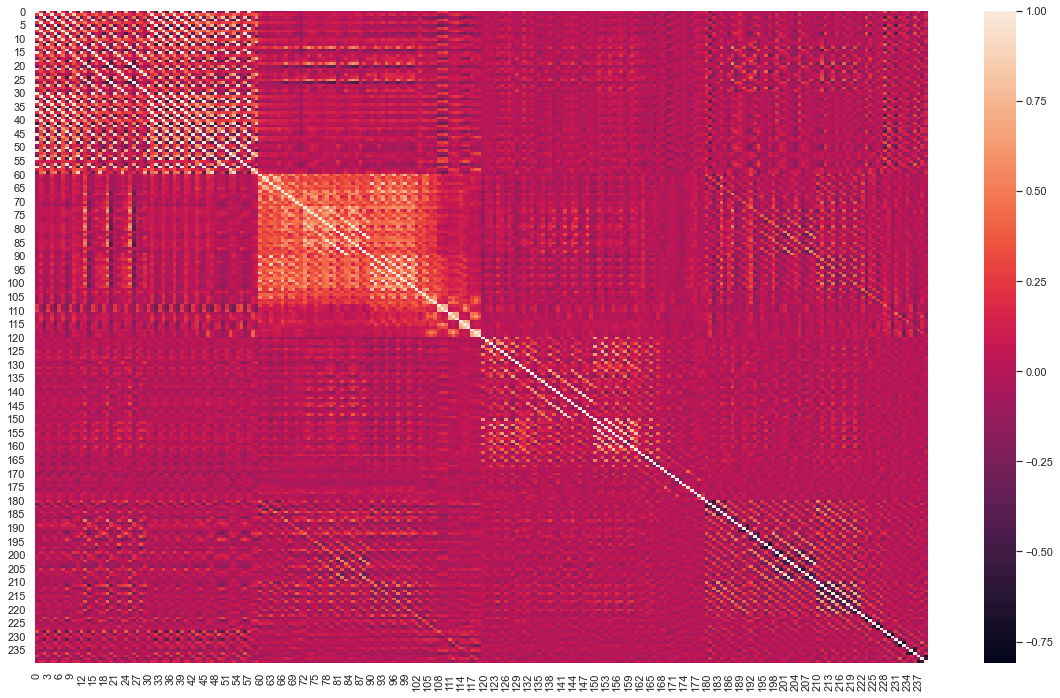

In [7]:
#check corelation of the descriptive features in train
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(descriptive_train.corr())

<AxesSubplot:>

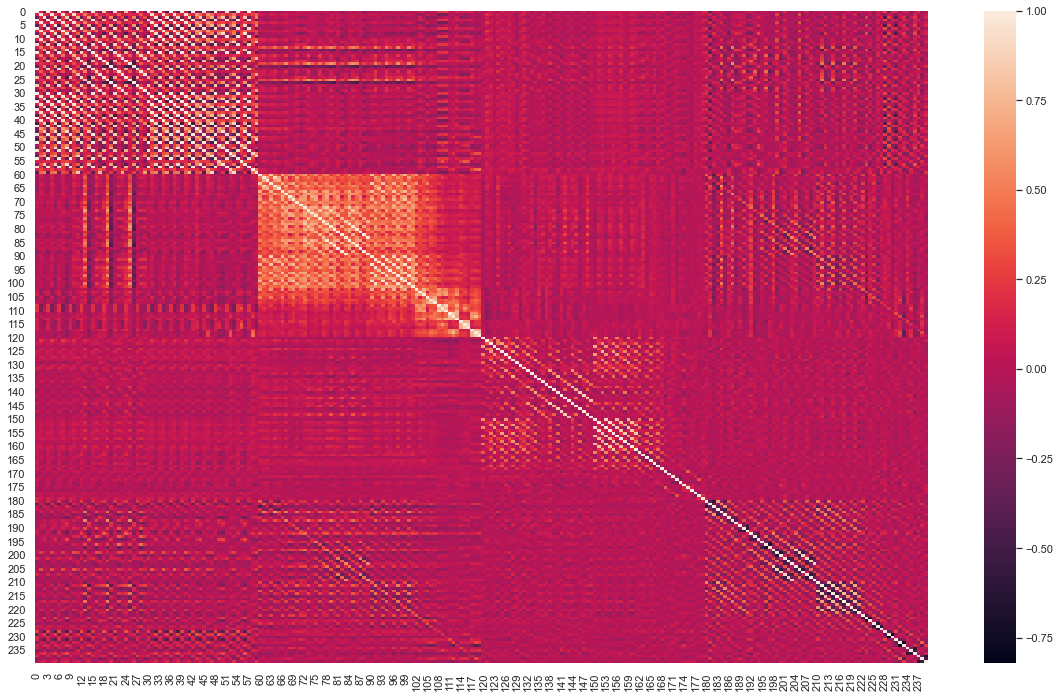

In [8]:
#check corelation of the descriptive features in test
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(descriptive_test.corr())

In [9]:
#Reduce dimentionality in the train set with PCA to 120 features
pca = PCA(n_components = 60)
data_pca_train = pca.fit_transform(descriptive_train)
descriptive_train_PCA = pd.DataFrame(data_pca_train)
descriptive_train_PCA

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-1.260881,-0.148332,-0.402781,-0.143879,-0.087947,0.128084,0.374692,0.584508,-0.173954,-0.036183,...,-0.088891,0.172356,-0.022408,0.142499,0.152388,0.000286,0.153970,-0.028421,-0.017561,-0.016839
1,0.719921,-0.473050,-0.569848,-0.893292,-0.457058,-0.833710,-0.389578,0.241851,0.224852,-0.331248,...,-0.131477,0.097014,-0.126502,-0.018415,0.008654,0.218596,0.043595,-0.077133,-0.031352,-0.006538
2,0.792253,-0.575033,-0.195162,-0.390378,0.415660,-0.168037,0.008926,0.377520,0.012536,-0.031708,...,-0.001248,0.125250,-0.005608,-0.097403,-0.011828,0.141376,0.080187,-0.093072,0.205986,0.005044
3,0.312606,-0.555099,-0.760001,-0.317658,-0.121496,0.103798,-0.000219,0.349117,0.004754,0.303251,...,0.000904,0.037977,-0.002172,-0.080130,-0.049480,-0.064849,-0.004718,0.103289,0.098408,-0.017392
4,0.989381,0.374707,-0.156281,-0.470926,0.183622,-0.277308,-0.506167,-0.012111,0.083893,0.450541,...,-0.048133,0.020260,0.105329,0.068809,0.057606,-0.018904,0.065421,-0.018714,-0.070028,0.067104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,-0.003688,0.214115,0.489539,-0.451778,-0.182614,-0.276083,-0.455749,0.158858,0.526058,-0.120684,...,0.182485,-0.033430,0.003105,-0.110239,0.087173,-0.052857,-0.052481,-0.114763,-0.059071,0.109784
536,-0.304766,1.018177,-0.110288,0.318051,-0.348969,0.042311,-0.041824,-0.229652,0.066416,0.035621,...,0.018655,-0.144292,-0.097384,0.095822,0.065297,0.058109,0.063746,-0.003122,0.014415,-0.015619
537,-0.332856,0.981110,-0.043880,0.434781,-0.181142,-0.406443,0.002537,-0.077744,-0.299151,0.032740,...,0.144862,0.012271,-0.016738,0.063989,0.110229,-0.084072,0.029860,0.050838,-0.107217,-0.007241
538,-1.576240,-0.370557,0.610644,0.093187,0.139371,-0.576437,0.092097,0.052286,0.205028,0.323831,...,0.019558,0.105148,-0.099266,0.021844,-0.013377,0.039468,0.082086,0.144484,0.068913,-0.045169


In [10]:
#Reduce dimentionality in the test set with PCA to 120 features
data_pca_test = pca.transform(descriptive_test)
descriptive_test_PCA = pd.DataFrame(data_pca_test)
descriptive_test_PCA

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-0.751838,-0.378950,-0.103393,0.324835,-0.825785,0.994305,-0.448083,0.587391,-0.573463,-0.468290,...,0.007711,0.197143,0.002411,-0.038262,-0.077476,0.095822,-0.138676,0.055198,-0.027073,-0.067973
1,0.653041,0.370348,-0.042826,0.039514,-0.181100,0.354325,-0.136062,0.471015,-0.303379,0.312502,...,-0.031875,0.045455,-0.046585,0.026953,0.045737,0.007554,-0.029908,0.024462,0.021226,0.021313
2,-1.123141,0.164725,-0.579742,-0.653001,-0.137350,-0.572046,0.546933,0.609297,-0.057321,-0.430936,...,0.020859,0.079520,-0.038499,-0.154020,-0.109108,0.017050,0.035496,-0.076815,-0.012136,0.105981
3,0.420763,-0.119484,-0.967828,0.217347,-0.168303,0.204251,0.768061,-0.416430,-0.174724,-0.064535,...,-0.015693,0.018230,0.032202,-0.151350,0.106988,0.080085,-0.077059,-0.091008,-0.089861,0.137534
4,-1.401977,-0.386648,-0.104661,-0.328299,0.386428,-0.321584,-0.187578,-0.186805,0.089427,0.249022,...,0.019553,0.028661,0.196310,-0.031645,-0.077158,-0.082531,-0.059794,-0.013134,-0.028324,-0.042756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,1.723855,0.904769,0.642853,0.096414,0.054551,0.024758,0.196464,0.266547,0.231024,-0.306222,...,-0.127851,-0.077199,-0.053169,0.085894,-0.102617,-0.071420,-0.037724,0.043248,-0.039516,0.045566
536,-0.613922,-0.144720,-0.305262,-0.311002,-0.451925,-0.891755,-0.026164,0.784343,0.106841,-0.089565,...,0.057453,0.265087,-0.013399,0.006664,0.015138,0.146301,0.046884,0.074448,0.000684,0.014250
537,0.444424,-0.149393,-0.055355,-0.232861,-0.449230,0.299002,0.280015,-0.521036,0.097540,0.174256,...,0.036975,0.058441,0.106737,0.026531,-0.010597,0.100448,0.076439,0.031688,0.058868,0.009990
538,-0.642130,0.048966,0.815220,-0.255624,0.041103,0.210185,-0.235518,0.119432,0.323236,0.151927,...,0.168118,0.044300,0.031061,-0.150818,0.060277,0.047710,-0.022413,-0.123554,-0.164157,0.045947


Random Forest Classifier
Accuracy: 0.7574
Macro Precision: 0.7758
Macro Recall: 0.7617
Macro F Score: 0.7501


Confusion Matrix Random Forest Classifier:


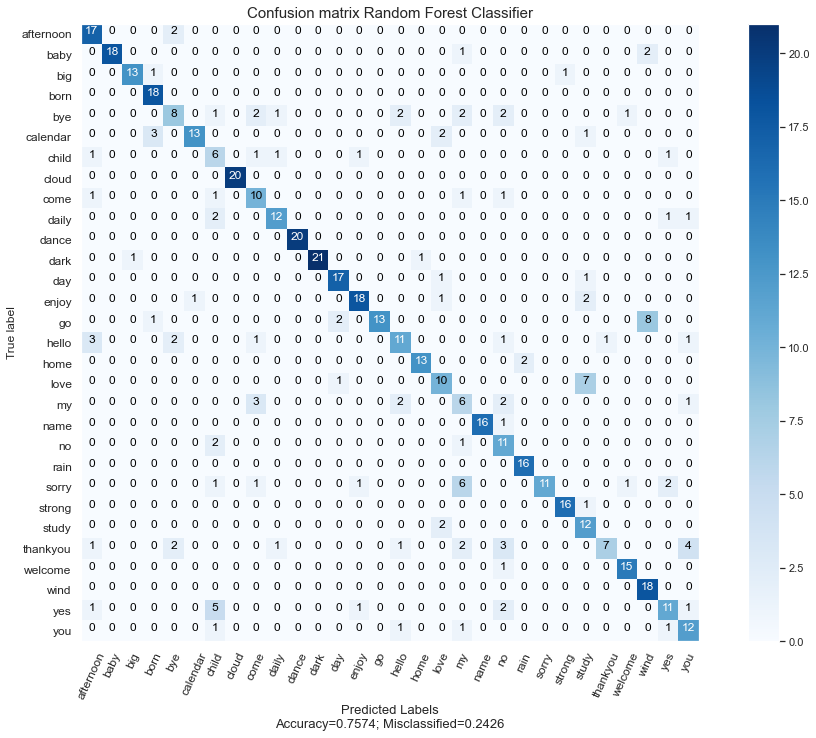

In [20]:
rfc_model = RandomForestClassifier(n_estimators=300,
                                max_features='auto',
                                bootstrap=True,
                                criterion='gini',
                                n_jobs = 8,
                                random_state = 42)
rfc_model.fit(descriptive_train_PCA ,target_train)
predictions = rfc_model.predict(descriptive_test_PCA)
plot_performance_results(rfc_model, "Random Forest Classifier", predictions, target_test, descriptive_train_PCA, descriptive_test_PCA)

SVM Classifier
Accuracy: 0.8222
Macro Precision: 0.8283
Macro Recall: 0.825
Macro F Score: 0.8169


Confusion Matrix SVM Classifier:


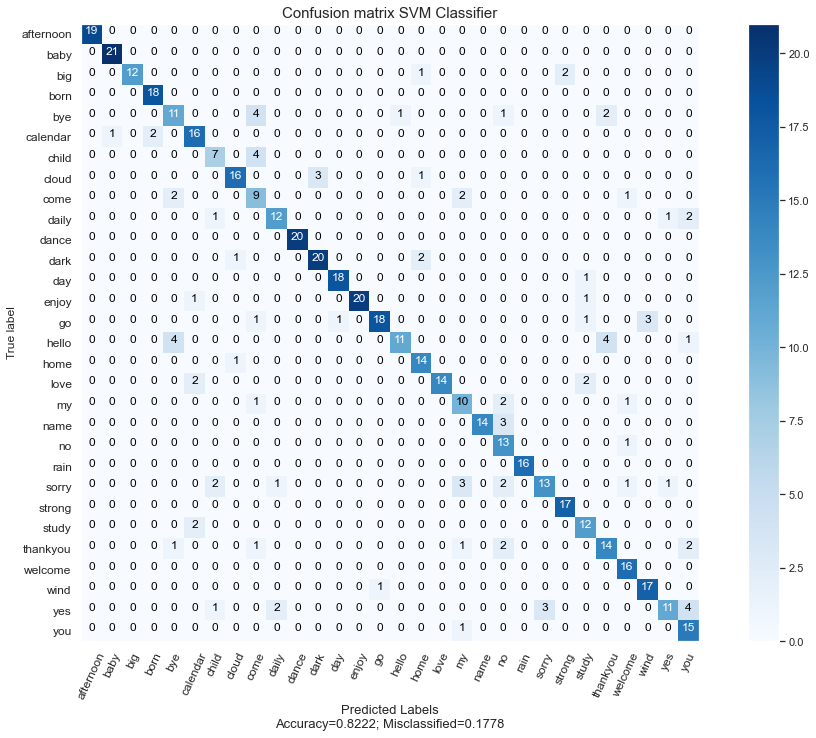

In [12]:
svm_model = svm.NuSVC(nu=0.2, decision_function_shape='ovo')
svm_model.fit(descriptive_train_PCA ,target_train)
predictions = svm_model.predict(descriptive_test_PCA)
plot_performance_results(svm_model, "SVM Classifier", predictions, target_test, descriptive_train_PCA, descriptive_test_PCA)